### Исходные данные
<p>Данные о пользователях из некольких городов и совершенные ими поездки на арендованных самокатах GoFast. Для совершения поездок необходимо мобильное приложение. Существует два способа пользованием сервисом: с подпиской и без.</p>

### Задача  
Проверить гпотезы от продакт-менеджера.
1. Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.
2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.
3. Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.
4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Выгрузим и выведем информацию о пользователях.

In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import norm
from math import factorial
from math import sqrt
plt.rcParams['figure.figsize']=(10,6)

try:
    data_users = pd.read_csv('/datasets/users_go.csv')
except: 
    data_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')    
try:
    data_rider = pd.read_csv('/datasets/rides_go.csv')
except: 
    data_rider = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
try:
    data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except: 
    data_subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

#### Шаг 1. Загрузка данных

In [296]:
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [297]:
data_rider.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [298]:
data_subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [299]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В таблице data_users представлены следующие данные:
<br>user_id - уникальный идентификатор пользователя (целочисленный тип)
<br>name - имя пользователя (строка)
<br>age - возраст (целочисленный тип)
<br>city - город (строка)
<br>subscription_type - тип подписки (free, ultra) (строка)
<br>Пропусков в данных нет.

In [300]:
data_rider.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В таблице data_rider представлены следующие данные:
<br>user_id - уникальный идентификатор пользователя (целое число)
<br>distance - расстояние, которое пользователь проехал в текущей сессии (в метрах) (число с плавающей точкой)
<br>duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку» (число с плавающей точкой)
<br>date - дата совершения поездки (строка)
<br>Пропусков в данных нет.
<br> Столбец с датой в дальнейшем преобразуем в формат даты.

In [301]:
data_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В таблице data_subscriptions представлены следующие данные:
<br>subscription_type - тип подписки (строка)
<br>minute_price - стоимость одной минуты поездки по данной подписке (целое число)
<br>start_ride_price - стоимость начала поездки (целое число)
<br>subscription_fee - стоимость ежемесячного платежа (целое число)
<br>Пропусков в данных нет.

Приведем столбец date к типу данных дата.

In [302]:
data_rider['date'] = pd.to_datetime(data_rider['date'], format=('%Y-%m-%d'))

Рассмотрим за какой период представлены данные.

In [303]:
pd.DatetimeIndex(data_rider['date']).year.unique()

Index([2021], dtype='int32', name='date')

Данные представлены только за 2021 год, добавим столбец с номером месяца для дальнейшего анализа.

In [304]:
data_rider['month'] = pd.DatetimeIndex(data_rider['date']).month

Проверим и обработаем при наличии пропуски и дубликаты.

In [305]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [306]:
data_users.duplicated().sum()

31

In [307]:
data_users = data_users.drop_duplicates()

In [308]:
data_rider.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [309]:
data_rider.duplicated().sum()

0

In [310]:
data_subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [311]:
data_subscriptions.duplicated().sum()

0

#### Шаг 3. Исследовательский анализ данных

Рассмотрим и визуализируем общую информацию о пользователях и поездках.

In [312]:
data_users['city'].value_counts().sort_values(ascending=False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

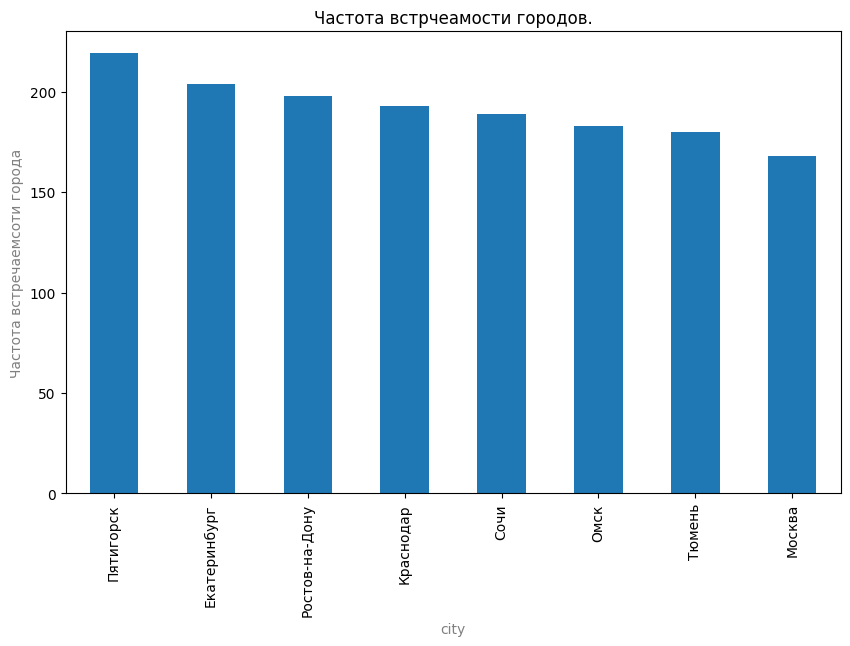

In [313]:
plt.title('Частота встрчеамости городов.')
plt.xlabel('Город', color='gray')
plt.ylabel('Частота встречаемсоти города', color='gray')
data_users['city'].value_counts().sort_values(ascending=False).plot.bar()
plt.show()

Больше всего людей пользуются прокатом самокатов в Пятигорске, меньше в Москве.

In [314]:
data_users['subscription_type'].value_counts()

subscription_type
free     835
ultra    699
Name: count, dtype: int64

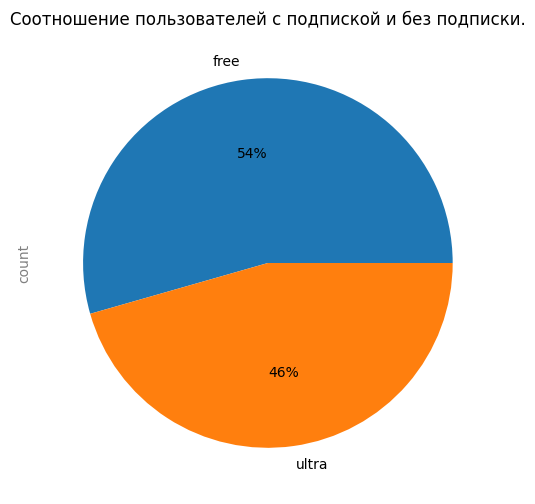

In [315]:
plt.title('Cоотношение пользователей с подпиской и без подписки.')
plt.ylabel('Подписка', color='gray')
data_users['subscription_type'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()

Пользователей без подписки - 835 человек, с подпиской - 699.

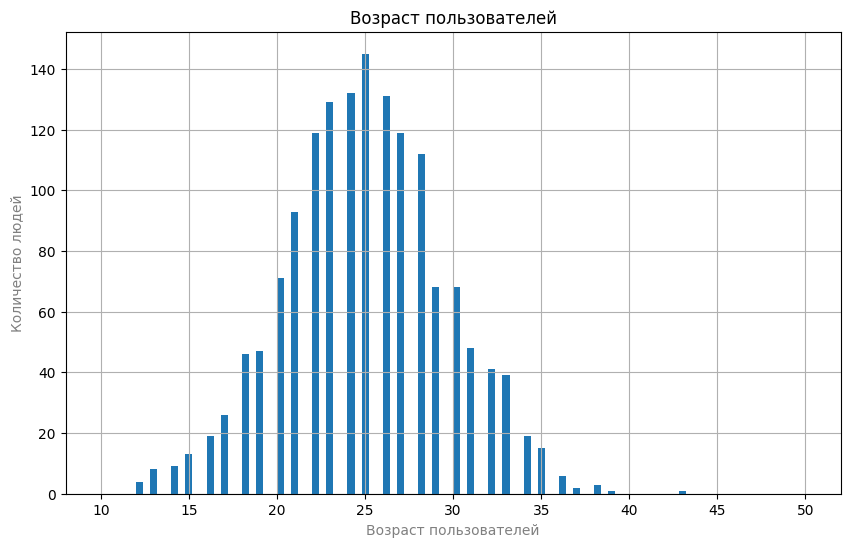

In [316]:
plt.title('Возраст пользователей')
plt.xlabel('Возраст пользователей', color='gray')
plt.ylabel('Количество людей', color='gray')
data_users['age'].hist(bins=100,range=(10,50),figsize=(10,6))
plt.show()

In [317]:
data_users['age'].value_counts()

age
25    145
24    132
26    131
23    129
22    119
27    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: count, dtype: int64

Основная масса - пользователи в возрасте от 20 до 30 лет.

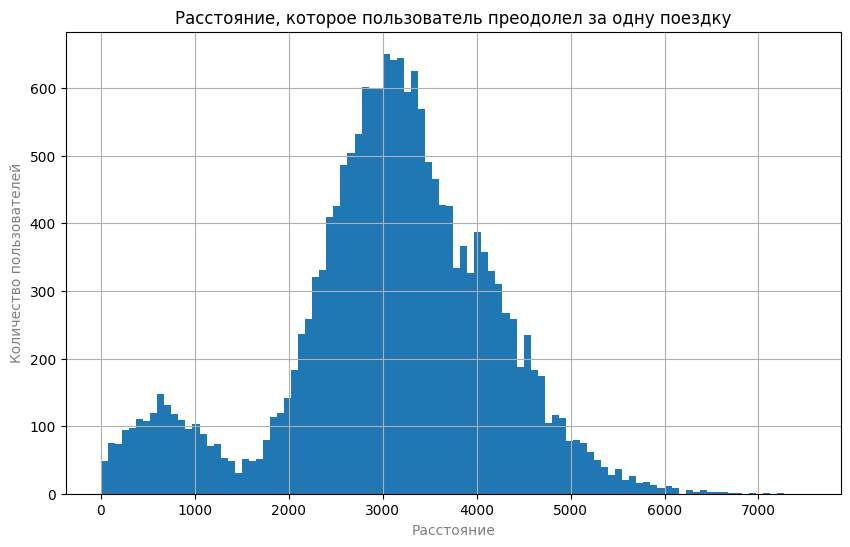

In [318]:
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние', color='gray')
plt.ylabel('Количество пользователей', color='gray')
data_rider['distance'].hist(bins=100,range=(0,7500),figsize=(10,6))
plt.show()


In [319]:
data_rider['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

В среденем пользователи проезжают за поездку 3000 метров, максимальное расстояние было 7211 метров. Можно заметить пик в 700 и 30000 метров. Между пиками нормальное распределние данных.

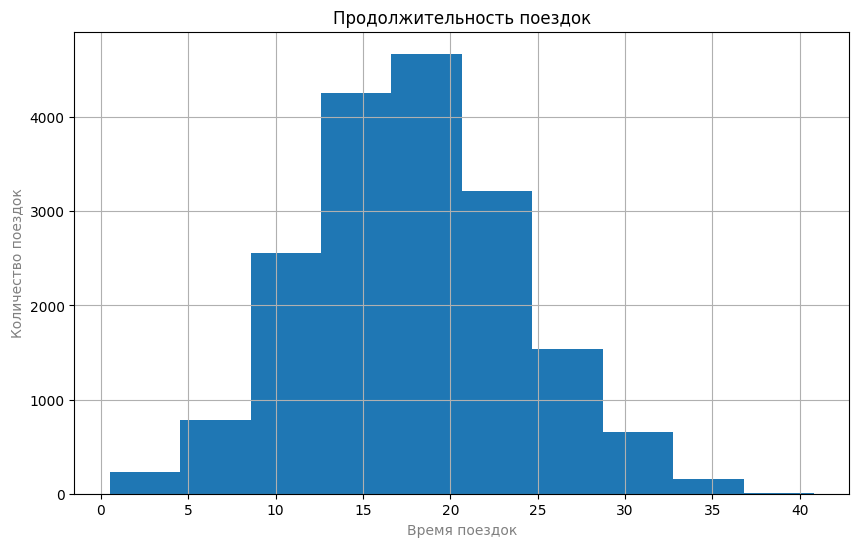

In [320]:
plt.title('Продолжительность поездок')
plt.xlabel('Время поездок', color='gray')
plt.ylabel('Количество поездок', color='gray')
data_rider['duration'].hist(figsize=(10,6))
plt.show()


In [321]:
data_rider['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Средняя длительность одной поездки равна 18 минутам, максимальная длительность была 40 минут. Есть также данные с длительностью меньше 5 минут, что может говорить о том, что пользователи передумали брать самокат или были какеи-то технические ошибки.

#### Шаг 4. Объединение данных

Объединими данные о пользователях, поездках и подписках в один датафрейм.

In [322]:
data = data_users.merge(data_rider, on='user_id')

In [323]:
data = data.merge(data_subscriptions, on='subscription_type')

In [324]:
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Выведем общую информацию об объединенном датафрейме.

In [325]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


Создадим датафреймы с данными о пользователях с подпиской и без.

In [326]:
data_free = data.query('subscription_type == "free"')

In [327]:
data_free

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [328]:
data_free.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int32         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.1+ MB


In [329]:
data_ultra = data.query('subscription_type == "ultra"')

In [330]:
data_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


In [331]:
data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int32         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 634.8+ KB


Поездок без подписки 11568, когда поездок с подпиской всего 6500.

Рассмотрим информацию о расстоянии и времени поездок для пользователей обеих категорий.

<Axes: >

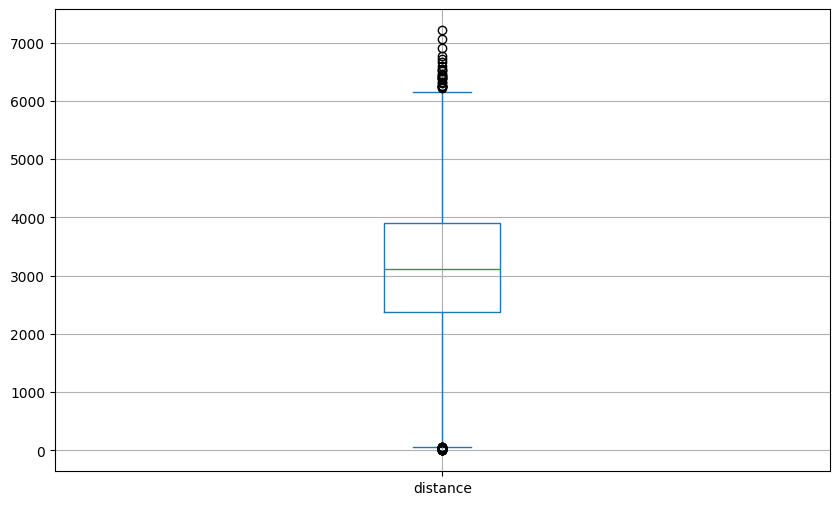

In [332]:
data_free['distance'].plot(kind='box', grid=True)

<Axes: >

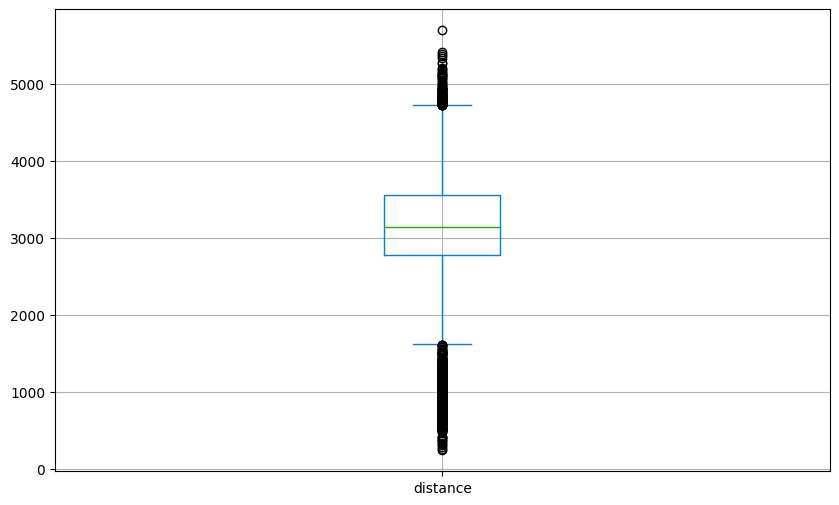

In [333]:
data_ultra['distance'].plot(kind='box', grid=True)

Рассмотрим распределения в одной системе координат.

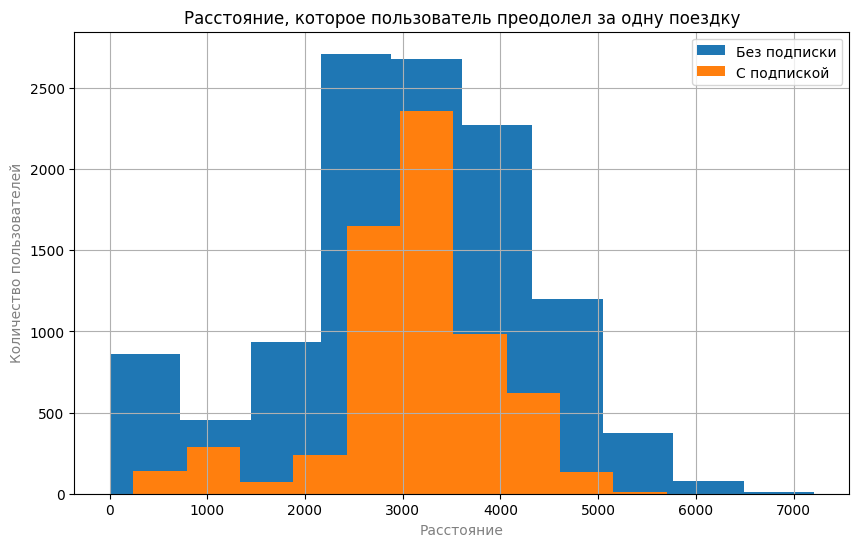

In [334]:
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние', color='gray')
plt.ylabel('Количество пользователей', color='gray')
data_free['distance'].hist()
data_ultra['distance'].hist()
plt.legend(['Без подписки', 'С подпиской'])
plt.show()

Пользователи без подписок больше, и они соотвестенно больше распределены по всей координатной прямой. При этом распределение пользователей с подписками находится ближе к центру, а значит из пользователей с подлпиской большее количество совершает поездки длительностью примернот 3500 метров. Распределение пользователей без подписок также стремится к центру, но при этом можно наблюдать порядка 1000 раз, когда пользователи проехали меньше 1000 метров.

Рассмотрим аналогично длительность поездок.

<Axes: >

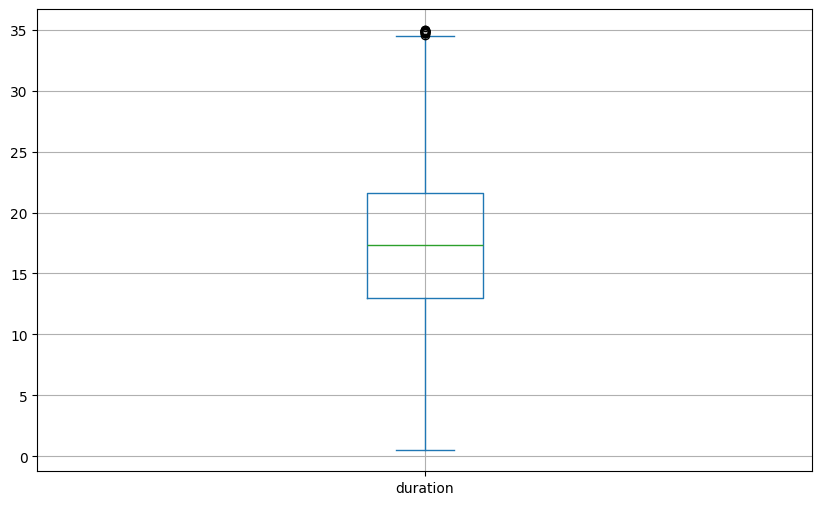

In [335]:
data_free['duration'].plot(kind='box', grid=True)

<Axes: >

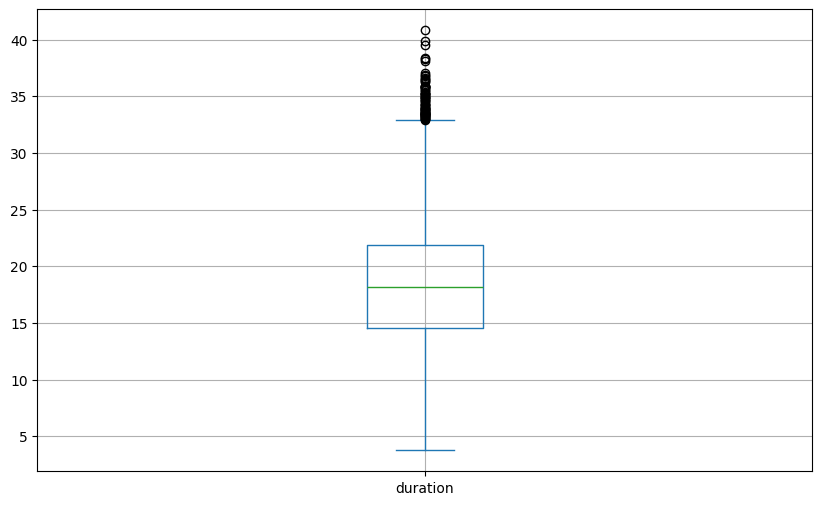

In [336]:
data_ultra['duration'].plot(kind='box', grid=True)

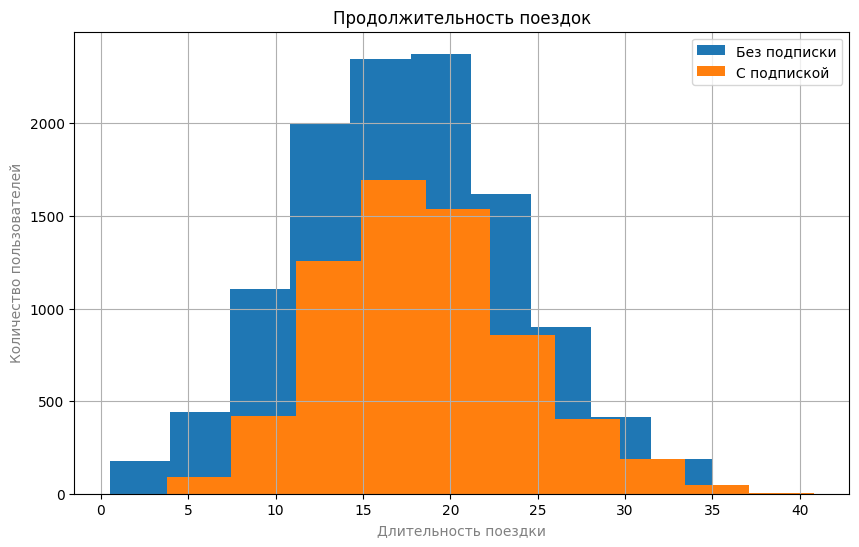

In [337]:
plt.title('Продолжительность поездок')
plt.xlabel('Длительность поездки', color='gray')
plt.ylabel('Количество пользователей', color='gray')
data_free['duration'].hist()
data_ultra['duration'].hist()
plt.legend(['Без подписки', 'С подпиской'])
plt.show()

Средняя длительность для пользователей с подпиской и без составляет около 15 - 20 минут. При этом максимальная длительность поездок у пользователей с подпсикой больше. Также у пользователи с подпиской нет поездок короче 3 минут, когда у пользователей без подписки таких поездок больше 100.

#### Шаг 5. Подсчёт выручки

Создадим датафрейм с подсчетом помесячно для каждого пользователя суммарного количества поездок, длительность и расстояния.

Добавим помесячную выручку в общую таблицу.

In [338]:
data['duration'] = np.ceil(data['duration'])

In [339]:
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


In [358]:
data_pivot = data.pivot_table(index=['user_id', 'month'], values=['distance','duration', 'subscription_fee','minute_price','start_ride_price'], aggfunc={'distance':['sum', 'count'], 'duration':'sum', 'subscription_fee':'mean','minute_price':'mean','start_ride_price':'mean'})

In [359]:
data_pivot

distance               duration minute_price start_ride_price  \
                 count           sum      sum         mean             mean   
user_id month                                                                 
1       1            2   7027.511294     42.0          6.0              0.0   
        4            1    754.159807      7.0          6.0              0.0   
        8            2   6723.470560     46.0          6.0              0.0   
        10           2   5809.911100     32.0          6.0              0.0   
        11           3   7003.499363     56.0          6.0              0.0   
...                ...           ...      ...          ...              ...   
1534    6            2   3409.468534     26.0          8.0             50.0   
        8            2   7622.453034     48.0          8.0             50.0   
        9            1   4928.173852     23.0          8.0             50.0   
        11           4  13350.015305     78.0          8.0             50.0   
        12           1   2371.711192     16.0          8.0             50.0   

              subscription_fee  
                          mean  
user_id month                   
1       1                199.0  
        4                199.0  
        8                199.0  
        10               199.0  
        11               199.0  
...                        ...  
1534    6                  0.0  
        8                  0.0  
        9                  0.0  
        11                 0.0  
        12                 0.0  

[11331 rows x 6 columns]

In [360]:
data_pivot.columns = ['count', 'dist_sum', 'dur_sum', 'minute_price','start_ride_price','subscription_fee']

In [361]:
data_pivot

count      dist_sum  dur_sum  minute_price  start_ride_price  \
user_id month                                                                 
1       1          2   7027.511294     42.0           6.0               0.0   
        4          1    754.159807      7.0           6.0               0.0   
        8          2   6723.470560     46.0           6.0               0.0   
        10         2   5809.911100     32.0           6.0               0.0   
        11         3   7003.499363     56.0           6.0               0.0   
...              ...           ...      ...           ...               ...   
1534    6          2   3409.468534     26.0           8.0              50.0   
        8          2   7622.453034     48.0           8.0              50.0   
        9          1   4928.173852     23.0           8.0              50.0   
        11         4  13350.015305     78.0           8.0              50.0   
        12         1   2371.711192     16.0           8.0              50.0   

               subscription_fee  
user_id month                    
1       1                 199.0  
        4                 199.0  
        8                 199.0  
        10                199.0  
        11                199.0  
...                         ...  
1534    6                   0.0  
        8                   0.0  
        9                   0.0  
        11                  0.0  
        12                  0.0  

[11331 rows x 6 columns]

In [362]:
data_pivot['revenue'] = data_pivot['subscription_fee'] + data_pivot['minute_price'] * data_pivot['dur_sum'] + data_pivot['start_ride_price']

In [363]:
data_pivot1 = data_pivot[['count', 'dist_sum', 'dur_sum', 'revenue']]

In [364]:
data_pivot1

count      dist_sum  dur_sum  revenue
user_id month                                       
1       1          2   7027.511294     42.0    451.0
        4          1    754.159807      7.0    241.0
        8          2   6723.470560     46.0    475.0
        10         2   5809.911100     32.0    391.0
        11         3   7003.499363     56.0    535.0
...              ...           ...      ...      ...
1534    6          2   3409.468534     26.0    258.0
        8          2   7622.453034     48.0    434.0
        9          1   4928.173852     23.0    234.0
        11         4  13350.015305     78.0    674.0
        12         1   2371.711192     16.0    178.0

[11331 rows x 4 columns]

#### Шаг 6. Проверка гипотез

1. Проверим гипотезу о среднем времени на поездки пользователей с подпиской и без.

H0 - Пользователи с подпиской и без тратят равное время.
<br>H1 - Пользователи с подпиской тратят время на поездки больше.

In [347]:
print(f'Среднее время поездки пользователей без подписки: {data_free["duration"].mean().round(2)}')
print(f'Среднее время поездки пользователей с подпиской: {data_ultra["duration"].mean().round(2)}')

Среднее время поездки пользователей без подписки: 17.39
Среднее время поездки пользователей с подпиской: 18.54


In [348]:
results_1 = st.ttest_ind(data_ultra["duration"], data_free["duration"], alternative='greater')

In [349]:
if results_1.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, а значит пользователи с подпиской и без тратят разное время.

2. Проверим гипотезу о среднем расстоянии 

H0 - Среднее расстояние не превышает 3130 метров.
<br>H1 - Среднее расстояние превышет 3130 метров.

In [350]:
print(f'Среднее расстояние пользователей : {data_ultra["distance"].mean().round(2)}')

Среднее расстояние пользователей : 3115.45


In [351]:
results_2 = st.ttest_1samp(data_ultra["distance"], 3130, alternative='less')

In [352]:
if results_2.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Не отвергаем нулевую гипотезу


Нулевая гипотеза не отвергнута, а значит среднне расстояние меньше 3130 метров.

3. Проверим гипотезу с помесячной выручкой

H0 - Помесячная выручка с подпиской  равно помесячной выручки без подпсики.
<br>H1 - Помесячная выручка с подпиской выше помесячной выручки без подпсики.

In [365]:
data_pivot

count      dist_sum  dur_sum  minute_price  start_ride_price  \
user_id month                                                                 
1       1          2   7027.511294     42.0           6.0               0.0   
        4          1    754.159807      7.0           6.0               0.0   
        8          2   6723.470560     46.0           6.0               0.0   
        10         2   5809.911100     32.0           6.0               0.0   
        11         3   7003.499363     56.0           6.0               0.0   
...              ...           ...      ...           ...               ...   
1534    6          2   3409.468534     26.0           8.0              50.0   
        8          2   7622.453034     48.0           8.0              50.0   
        9          1   4928.173852     23.0           8.0              50.0   
        11         4  13350.015305     78.0           8.0              50.0   
        12         1   2371.711192     16.0           8.0              50.0   

               subscription_fee  revenue  
user_id month                             
1       1                 199.0    451.0  
        4                 199.0    241.0  
        8                 199.0    475.0  
        10                199.0    391.0  
        11                199.0    535.0  
...                         ...      ...  
1534    6                   0.0    258.0  
        8                   0.0    434.0  
        9                   0.0    234.0  
        11                  0.0    674.0  
        12                  0.0    178.0  

[11331 rows x 7 columns]

In [389]:
print(f'Средняя помесячная выручка пользователей с подпиской: {np.round(data_pivot.query("subscription_fee == 199")["revenue"].mean(), 2)}')
print(f'Средняя помесячная выручка пользователей без подписки: {np.round(data_pivot.query("subscription_fee == 0")["revenue"].mean(), 2)}')

Средняя помесячная выручка пользователей с подпиской: 362.79
Средняя помесячная выручка пользователей без подписки: 293.56


In [392]:
results_3 = st.ttest_ind(data_pivot.query("subscription_fee == 0")["revenue"], data_pivot.query("subscription_fee == 199")["revenue"], alternative='less')

In [393]:
if results_3.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу в пользу алтерантивной, а это значит, что средння выручка пользователй без подписки ниже пользователей с подпиской.

4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ: нам понадобился двухвыборочный t-тест для зависимых выборок (st.ttest_rel) 

Односторонней

#### Шаг 7. Распределения

### Вывод
В результате данной работы были проделаны следующие этапы:
1. Была выполнена предобработка данных, в результате которой были удалены 31 дубликаты, приведен тип данных в формат даты в столбце с датой.
2. Рассмотрена информация о пользователях:
<br> 1) Больше всего людей пользуются прокатом самокатов в Пятигорске, меньше в Москве.
<br>2) Пользователей без подписки - 835 человек, с подпиской - 699. Пользователи с подпиской составляют 54% от общего количества.
<br>3) Основная масса - пользователи в возрасте от 20 до 30 лет. Максимально количество людей в возрасте 25 лет.
<br>4) В среденем пользователи проезжают за поездку 3000 метров, максимальное расстояние было 7211 метров. Наблюдаются два пика - около 700 метров и  около 3200 метров. Между пиками значения нормально распределены.
<br>5) Средняя длительность одной поездки равна 18 минутам, максимальная длительность была 40 минут. Есть также данные с длительностью меньше 5 минут, что может говорить о том, что пользователи передумали брать самокат или были какеи-то технические ошибки.
3. Сделаны выводы о длительности и расстоянии дял пользователей с подпиской и без:
Пользователи с подлпиской большее количество раз совершают поездки длительностью примернот 3500 метров. 
Средняя длительность для пользователей с подпиской и без составляет около 15 - 20 минут. При этом максимальная длительность поездок у пользователей с подпсикой больше. Также у пользователи с подпиской нет поездок короче 3 минут, когда у пользователей без подписки таких поездок больше 100.
4. Подчитана помесяная выручка для пользователей.
5. В ходе проверики гипотез сделаны следующие выводы:
<br>1) Пользователи с подпиской и без тратят разное время.
<br> 2) Cреднее расстояние, которое проезжают пользователи меньше 3130 метров.
<br> 3) Средння выручка пользователй без подписки ниже пользователей с подпиской.